## 데이터 읽기

In [1]:
import pandas as pd
df = pd.read_csv("bing_news_shuffle.csv", encoding="UTF-8")
df

,Unnamed: 0,name,description,category
0,0,Coronavirus: Largest study suggests elderly an...,Health officials in China have published the f...,World
1,1,Coronavirus: Largest study suggests elderly an...,Health officials in China have published the f...,World
2,2,'From bad to worse': Dashed hopes may deter ma...,"DUBAI (Reuters) - Confrontation with America, ...",World
3,3,Caroline Flack’s best friend shares heartbreak...,CAROLINE Flack's close friend who was with her...,World
4,4,Healthcare reform gives Sanders a headache in ...,Bernie Sanders heads in to Saturday’s Nevada c...,World
...,...,...,...,...
704,704,"Over 674,000 people sign two separate petition...",Hundreds of thousands of people have signed th...,UK
705,705,Love Island star Caroline Flack said she would...,The former Love Island presenter was found dea...,UK
706,706,Police investigate after girl heard screaming ...,Police are looking to identify a girl who was ...,UK
707,707,Mum and son forced to flee home as they 'lose ...,A mother and her son have been forced to move ...,UK


## 불용어 설정 및 품사 타입 변환

In [2]:
import nltk

In [3]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
lem = WordNetLemmatizer()
stop_words = stopwords.words('english')
lemm_dic = {"NN":"n", "JJ":"a", "VB":"v", "RB":"r"}

## 텍스트 전처리 함수 정의

In [4]:
def clearText(description):
    tokens = nltk.word_tokenize(description)
    
    tokens = [token.lower() for token in tokens if len(token) > 2]
    
    tokens_clean = [token for token in tokens if not token in stop_words]
    
    tokens_tagged = nltk.pos_tag(tokens_clean)
    
    tokens_tagged = [(word, pos[:2]) for word, pos in tokens_tagged if pos[:2] in ['NN', 'JJ', 'VB', 'RB']]
    
    tokens_tagged = [lem.lemmatize(word, lemm_dic[pos])
                    for word, pos in tokens_tagged]
    
    return " ".join(tokens_tagged)

## 텍스트 전처리 적용

In [5]:
df["description_clear"] = df["description"].apply(clearText)
df

,Unnamed: 0,name,description,category,description_clear
0,0,Coronavirus: Largest study suggests elderly an...,Health officials in China have published the f...,World,health official china publish first detail cas...
1,1,Coronavirus: Largest study suggests elderly an...,Health officials in China have published the f...,World,health official china publish first detail cas...
2,2,'From bad to worse': Dashed hopes may deter ma...,"DUBAI (Reuters) - Confrontation with America, ...",World,dubai reuters confrontation economic hardship ...
3,3,Caroline Flack’s best friend shares heartbreak...,CAROLINE Flack's close friend who was with her...,World,caroline flack close friend hour kill share he...
4,4,Healthcare reform gives Sanders a headache in ...,Bernie Sanders heads in to Saturday’s Nevada c...,World,bernie sander head saturday nevada caucus fron...
...,...,...,...,...,...
704,704,"Over 674,000 people sign two separate petition...",Hundreds of thousands of people have signed th...,UK,hundred thousand people sign petition picture ...
705,705,Love Island star Caroline Flack said she would...,The former Love Island presenter was found dea...,UK,former love island presenter find dead home sa...
706,706,Police investigate after girl heard screaming ...,Police are looking to identify a girl who was ...,UK,police look identify heard scream street barnh...
707,707,Mum and son forced to flee home as they 'lose ...,A mother and her son have been forced to move ...,UK,mother son force move hotel raw sewage flood w...


## 데이터 분할

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        df["description_clear"],
        df["category"],
        test_size = 0.2
        )

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

In [8]:
vectorizer = TfidfVectorizer(min_df = 2,
                            ngram_range=(1, 2),
                            strip_accents="unicode",
                            norm='l2')

In [9]:
X_train_vector = vectorizer.fit_transform(X_train)

In [10]:
X_test_vector = vectorizer.transform(X_test)

In [11]:
from xgboost import XGBClassifier
xgb_clf = XGBClassifier(n_estimators=30,
                       nthread= -1)
xgb_clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=30, n_jobs=1,
              nthread=-1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## 파람 설정

In [12]:
params = {'max_dpeth' : [3, 5, 7],
         'min_child_weight' : [3, 5, 7],
         'colsample_bytree' : [0.1, 0.5, 1.0],
         'learning_rate':[0.001, 0.01, 0.1],
         'num_class':[8]}

In [13]:
from sklearn.model_selection import GridSearchCV

gridcv = GridSearchCV(xgb_clf, param_grid=params, n_jobs=10)
gridcv

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=30, n_jobs=1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=10,
             param_grid={'colsample_bytree': [0.1, 0.5, 1.0],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_dpeth': [3, 5

## XGBoost 적용

In [14]:
import time
start_time = time.time()
gridcv.fit(X_train_vector,
          y_train,
          eval_set = [(X_test_vector, y_test)])


c:\library\python\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


[0]	validation_0-merror:0.676056
[1]	validation_0-merror:0.65493


c:\library\python\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[2]	validation_0-merror:0.640845
[3]	validation_0-merror:0.640845
[4]	validation_0-merror:0.626761
[5]	validation_0-merror:0.626761
[6]	validation_0-merror:0.626761
[7]	validation_0-merror:0.640845
[8]	validation_0-merror:0.65493
[9]	validation_0-merror:0.598592
[10]	validation_0-merror:0.612676
[11]	validation_0-merror:0.619718
[12]	validation_0-merror:0.598592
[13]	validation_0-merror:0.584507
[14]	validation_0-merror:0.591549
[15]	validation_0-merror:0.591549
[16]	validation_0-merror:0.584507
[17]	validation_0-merror:0.584507
[18]	validation_0-merror:0.591549
[19]	validation_0-merror:0.584507
[20]	validation_0-merror:0.591549
[21]	validation_0-merror:0.584507
[22]	validation_0-merror:0.570423
[23]	validation_0-merror:0.570423
[24]	validation_0-merror:0.570423
[25]	validation_0-merror:0.570423
[26]	validation_0-merror:0.577465
[27]	validation_0-merror:0.584507
[28]	validation_0-merror:0.584507
[29]	validation_0-merror:0.577465


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=30, n_jobs=1,
                                     nthread=-1, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_jobs=10,
             param_grid={'colsample_bytree': [0.1, 0.5, 1.0],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_dpeth': [3, 5

In [15]:
print(f"실행 시간 : {time.time() - start_time}s")

실행 시간 : 157.67434930801392s


In [16]:
pred = gridcv.predict(X_test_vector)
pred

array(['Health', 'ScienceAndTechnology', 'Politics',
       'ScienceAndTechnology', 'ScienceAndTechnology', 'UK',
       'Entertainment', 'Sports', 'Health', 'Entertainment',
       'ScienceAndTechnology', 'ScienceAndTechnology', 'Health',
       'Business', 'Sports', 'Health', 'Politics', 'Politics',
       'ScienceAndTechnology', 'ScienceAndTechnology', 'Politics',
       'ScienceAndTechnology', 'ScienceAndTechnology', 'Sports',
       'Politics', 'Sports', 'ScienceAndTechnology',
       'ScienceAndTechnology', 'Politics', 'Sports', 'Sports',
       'ScienceAndTechnology', 'Health', 'Entertainment', 'Business',
       'Health', 'ScienceAndTechnology', 'Politics',
       'ScienceAndTechnology', 'UK', 'Health', 'Business', 'UK', 'UK',
       'Entertainment', 'Business', 'Politics', 'Health', 'Health',
       'Politics', 'Entertainment', 'Politics', 'ScienceAndTechnology',
       'Health', 'ScienceAndTechnology', 'Entertainment', 'Business',
       'ScienceAndTechnology', 'ScienceAndTec

In [17]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, pred))

0.4225352112676056


In [18]:
ftr_importances_values = gridcv.best_estimator_.feature_importances_
ftr_importances_values = pd.Series(ftr_importances_values, index = vectorizer.get_feature_names()).sort_values(ascending=False)[:20]
ftr_importances_values

league          0.041209
police          0.030036
side            0.021853
manchester      0.019939
star            0.019414
storm           0.018853
player          0.017757
minister        0.016935
host            0.016070
market          0.016007
club            0.015784
storm dennis    0.015368
road            0.015332
island          0.014201
flood           0.014187
warning         0.013672
study           0.013557
hospital        0.013387
chelsea         0.013356
adviser         0.013023
dtype: float32

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

                      precision    recall  f1-score   support

            Business       0.55      0.32      0.40        19
       Entertainment       0.28      0.42      0.33        12
              Health       0.15      0.21      0.17        19
            Politics       0.55      0.57      0.56        21
ScienceAndTechnology       0.44      0.58      0.50        24
              Sports       0.77      0.53      0.62        19
                  UK       0.50      0.33      0.40        18
               World       0.43      0.30      0.35        10

            accuracy                           0.42       142
           macro avg       0.46      0.41      0.42       142
        weighted avg       0.47      0.42      0.43       142



In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

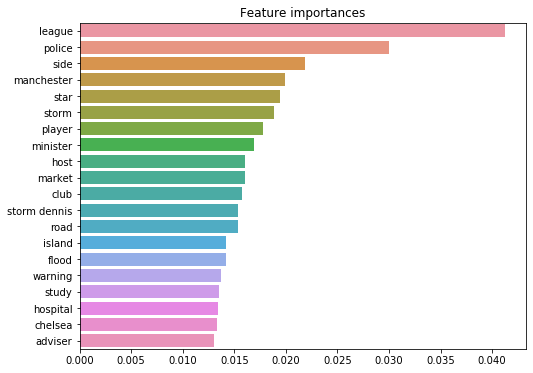

In [21]:
plt.figure(figsize=(8, 6))
plt.title("Feature importances")
sns.barplot(x=ftr_importances_values, y=ftr_importances_values.index)
plt.show()